# Задача

Отрисуйте карты Рамачандрана для 3 любых соединений из базы PDB.

# Решение

На данный момент уже существует несколько готовых решений по построению карт Рамачандрана:
* Библиотека Pyrama для построения карт: https://github.com/gerdos/PyRAMA
* Подробное описание и код для построения карт Рамачандрана без использования библиотеки Biopython и без учета границ построения карт: https://azevedolab.net/resources/rama_plot_py.pdf 

Так как в описании задания отсуствуют какие-либо требования к решению, а конкретно - можно или нет использовать сторонние библиотеки или код, мной представлено построение карт с помощью библиотеки Pyrama и свое собственное решение.

В качестве соединений для построение карт Рамачандрана были выбраны 4ciw, 4cs4 и 4d2i, которые предварительно были загружены из базы PDB.

# Построение карт с помощью Pyrama

Прежде всего необходимо установить библиотеку pyrama

In [3]:
!pip install pyrama

Pyrama позволяет построить карты Рамачандрана в терминале с помощью комманд: pyrama 4ciw.pdb, pyrama 4cs4.pdb и pyrama 4d2i.pdb

Также можно построить карты Рамачандра используя функции из библиотеки calc_ramachandran и plot_ramachandran.

Data/4ciw.pdb


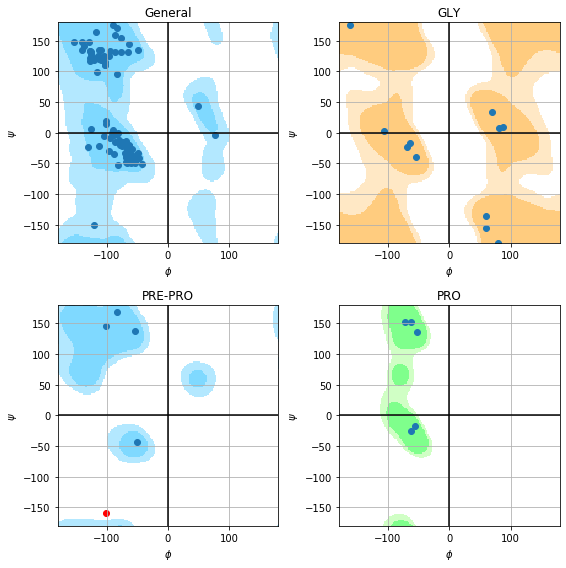

Data/4cs4.pdb


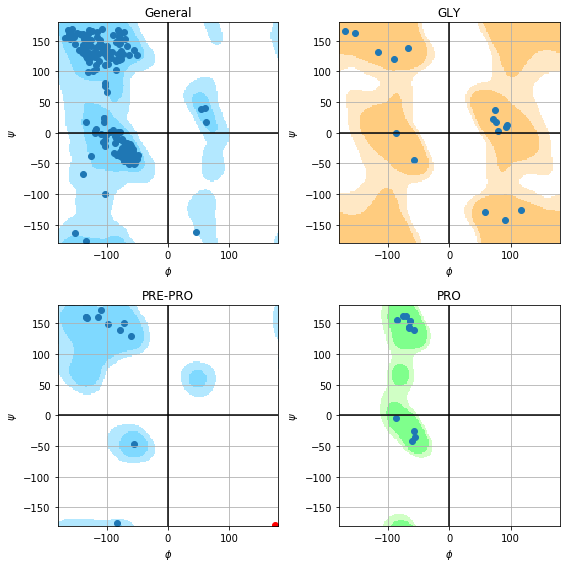

Data/4d2i.pdb


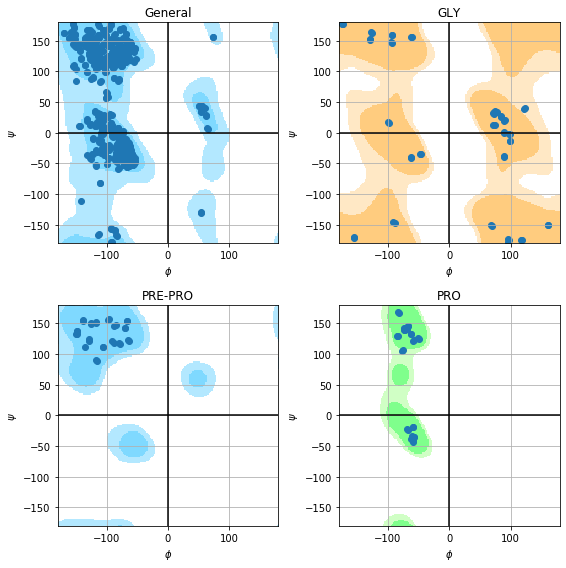

In [71]:
import matplotlib.pyplot as plt
from pyrama import calc_ramachandran, plot_ramachandran
import pathlib
import warnings
warnings.filterwarnings('ignore')

dataset_file = pathlib.Path('').joinpath('Data')
data = [file for file in dataset_file.iterdir() if file.suffix == '.pdb']
for i in data:
    print(i)
    plt.figure(figsize=(8,8))
    normals, outliers = calc_ramachandran([i])
    plot_ramachandran(normals, outliers)

Красным помечены точки, которые находятся в недопустимых областях. Как мы видим для 4ciw.pdb и 4cs4.pdb было найдено по одной такой точке. 

# Собственное построение карт

В основе построения карт лежат почти те же самые принципы, что в библиотеке Pyrama. Но в отличие от pyrama здесь аминокислотные остатки не будут разбиваться на 4 группы (общая, глицин, пролин, препролин). Для парсинга pdb файлов используется библиотека biopython. После определения полипептидов используется метод get_phi_psi_list, который рассчитывает углы $\psi$ и $\phi$. Данный метод находит атомы, образующие остов полипептидной цепи — N, Cα и C. Затем он рассчитывает между ними угол с помощью функции calc_dihedral. Также здесь используется файл edges.data, который хранит в себе информацию о предпочтительных, разрешенных и «особенно разрешенных» областях, определенных ProCheck.

In [78]:
import math
import matplotlib.pyplot as plt
from Bio import PDB
import numpy as np
import matplotlib.colors as mplcolors
from matplotlib import colors

def ramachandran(file):
    RAMA_PREFERENCES = {
        "cmap": mplcolors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF']),
        "bounds": [0, 0.0005, 0.02, 1]}
    
    RAMA_PREF_VALUES = np.full((360, 360), 0, dtype=np.float64)
    with open('edges.data') as fn:
        for line in fn:
            if line.startswith("#"):
                continue
            else:
                x = int(float(line.split()[1]))
                y = int(float(line.split()[0]))
                RAMA_PREF_VALUES[x + 180][y + 180] \
                     = RAMA_PREF_VALUES[x + 179][y + 179] \
                     = RAMA_PREF_VALUES[x + 179][y + 180] \
                     = RAMA_PREF_VALUES[x + 180][y + 179] \
                     = float(line.split()[2])
    
    normals = {"x": [], "y": []}
    outliers = {"x": [], "y": []}
    
    structure = PDB.PDBParser().get_structure('input_structure', file)
    for model in structure:
            for chain in model:
                polypeptides = PDB.PPBuilder().build_peptides(chain)
                for poly_index, poly in enumerate(polypeptides):
                    phi_psi = poly.get_phi_psi_list()
                    for res_index, residue in enumerate(poly):
                        res_name = "{}".format(residue.resname)
                        res_num = residue.id[1]
                        phi, psi = phi_psi[res_index]
                        if phi and psi:                     
                            if RAMA_PREF_VALUES[int(math.degrees(psi)) + 180][int(math.degrees(phi)) + 180] < \
                                    RAMA_PREFERENCES["bounds"][1]:
                                outliers["x"].append(math.degrees(phi))
                                outliers["y"].append(math.degrees(psi))
                            else:
                                normals["x"].append(math.degrees(phi))
                                normals["y"].append(math.degrees(psi))
                            
    plt.imshow(RAMA_PREF_VALUES, cmap=RAMA_PREFERENCES["cmap"],
                norm=colors.BoundaryNorm(RAMA_PREFERENCES["bounds"], RAMA_PREFERENCES["cmap"].N),
                extent=(-180, 180, 180, -180))
    plt.title(file)
    plt.scatter(normals["x"], normals["y"])
    plt.scatter(outliers["x"], outliers["y"], color="red")
    plt.xlim([-180, 180])
    plt.ylim([-180, 180])
    plt.plot([-180, 180], [0, 0], color="black")
    plt.plot([0, 0], [-180, 180], color="black")
    plt.locator_params(axis='x', nbins=7)
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\psi$')
    plt.grid()
    plt.show()

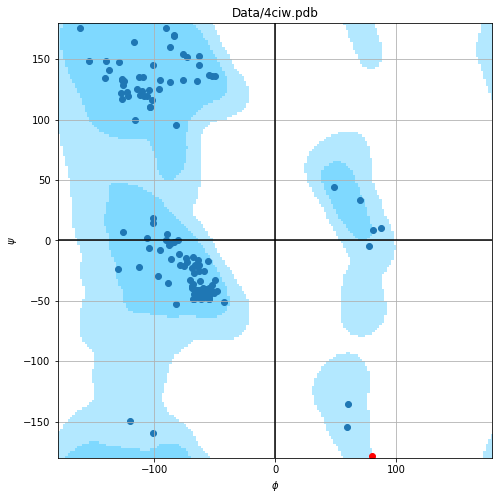

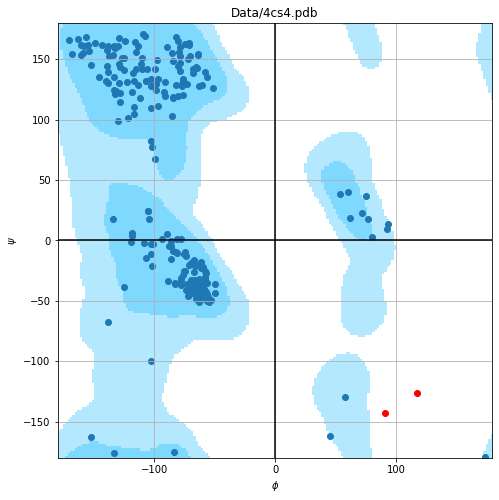

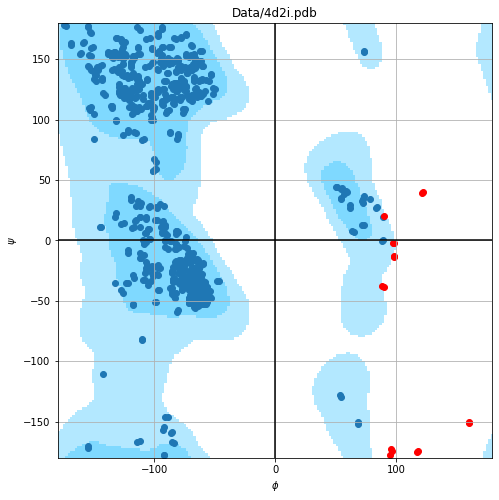

In [80]:
for i in data:
    plt.figure(figsize=(8,8))
    ramachandran(i)